In [129]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from tqdm import tqdm, trange

## Power-law bump simulator

In [130]:
def bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b):
    """ Forward model for a Gaussian bump (amp_s, mu_s, std_s) on top of a power-law background (amp_b, exp_b).
    """
    x_b = amp_b * (y ** exp_b)  # Power-law background
    x_s = amp_s * np.exp(-((y - mu_s) ** 2) / (2 * std_s ** 2))  # Gaussian signal

    x = x_b + x_s  # Total mean signal

    return x

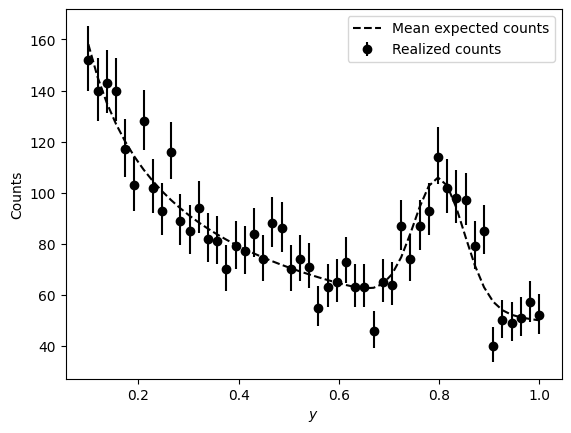

In [131]:
def poisson_interval(k, alpha=0.32): 
    """ Uses chi2 to get the poisson interval.
    """
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0: 
        low = 0.0
    return k - low, high - k

y = np.linspace(0.1, 1, 50)  # Dependent variable

# Mean expected counts
x_mu = bump_forward_model(y, 
                    amp_s=50, mu_s=0.8, std_s=0.05,  # Signal params
                    amp_b=50, exp_b=-0.5)  # Background params

# Realized counts
x = np.random.poisson(x_mu)
x_err = np.array([poisson_interval(k) for k in x.T]).T

# Plot
plt.plot(y, x_mu, color='k', ls='--', label="Mean expected counts")
plt.errorbar(y, x, yerr=x_err, fmt='o', color='k', label="Realized counts")

plt.xlabel("$y$")
plt.ylabel("Counts")

plt.legend()

In [132]:
def bump_simulator(thetas, y):
    """ Simulate samples from the bump forward model given theta = (amp_s, mu_s) and abscissa points y.
    """
    amp_s, mu_s = thetas
    std_s, amp_b, exp_b = 0.05, 50, -0.5
    x_mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    x = np.random.poisson(x_mu)
    return x

# Test it out
bump_simulator([50, 0.8], y)

array([171, 159, 140, 118, 123, 114, 105, 124, 101,  86, 101,  86,  85,
        81, 110, 101,  75,  80,  82,  68,  70,  63,  79,  71,  57,  75,
        60,  78,  73,  64,  68,  63,  75,  68,  81,  71,  98, 101, 109,
       100, 106,  78,  64,  54,  49,  62,  53,  50,  54,  51])

## Training data

In [133]:
n_train = 50_000

# Simulate training data
theta_samples = np.random.uniform(low=[0, 0], high=[200, 1], size=(n_train, 2))  # Parameter proposal
x_samples = np.array([bump_simulator(theta, y) for theta in tqdm(theta_samples)])

100%|██████████| 50000/50000 [00:00<00:00, 62598.60it/s]


In [134]:
# Normalize the data
x_mean = x_samples.mean()
x_std = x_samples.std()
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(axis=0)
theta_std = theta_samples.std(axis=0)
theta_samples = (theta_samples - theta_mean) / theta_std

## Neural posterior estimator model

In [188]:
import sys
sys.path.append("../")

import jax
import optax
import flax.linen as nn

from models.maf import MaskedAutoregressiveFlow
from models.nsf import NeuralSplineFlow

In [236]:
class MLP(nn.Module):
    """ A simple MLP in Flax. This will be the feature extractor.
    """
    hidden_dim: int = 32
    out_dim: int = 2
    n_layers: int = 2

    @nn.compact
    def __call__(self, x):
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.gelu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x

In [238]:
class NeuralPosteriorEstimator(nn.Module):
    """ A neural posterior estimator.
    """
    d_param: int = 2  # Param dim
    d_hidden: int = 64  # Hidden dim of MLP and flow
    d_summaries: int = 16  # Number of summaries from MLP
    n_layers: int = 4  # Number of layers in MLP
    n_transforms: int = 6  # Number of flow transforms

    def setup(self):
        self.featurizer = MLP(hidden_dim=self.d_hidden, out_dim=self.d_summaries, n_layers=self.n_layers)
        self.flow = MaskedAutoregressiveFlow(n_dim=self.d_param, n_context=self.d_summaries, hidden_dims=2 * [self.d_hidden], n_transforms=self.n_transforms, activation="tanh", use_random_permutations=False)

    @nn.compact
    def __call__(self, x, theta):

        # Pass data through MLP to get summaries
        context =self.featurizer(x)

        # Use summaries as context for flow
        log_prob = self.flow(theta, context)

        return log_prob

In [239]:
npe = NeuralPosteriorEstimator()

key = jax.random.PRNGKey(0)
log_prob, params = npe.init_with_output(rngs=key, x=x_samples[:16], theta=theta_samples[:16])

log_prob

Array([-1.7746974, -1.9767084, -3.3885179, -3.3411727, -2.5347002,
       -2.8596387, -2.7574067, -2.4476223, -2.9018464, -1.8135326,
       -2.7627273, -2.8596678, -2.3531556, -3.523026 , -2.882647 ,
       -1.8737776], dtype=float32)

## Training

In [240]:
@jax.jit
def loss_fn(params, x, theta):
    log_prob = npe.apply(params, x, theta)
    return -log_prob.mean()

In [242]:
opt = optax.sgd(learning_rate=1e-4, momentum=0.99, nesterov=True)
opt_state = opt.init(params)

In [243]:
n_steps = 3000
n_batch = 128

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))

        x_batch, theta_batch = x_samples[idx], theta_samples[idx]
        
        loss, grads = jax.value_and_grad(loss_fn)(params, x_batch, theta_batch)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

100%|██████████| 3000/3000 [00:51<00:00, 58.13it/s, val=0.6358305]    


## Test

In [244]:
n_test = 1000

# Simulate training data
theta_samples_test = np.random.uniform(low=[0, 0], high=[200, 1], size=(n_test, 2))  # Parameter proposal
x_samples_test = np.array([bump_simulator(theta, y) for theta in tqdm(theta_samples_test)])

# Normalize the data
x_samples_test = (x_samples_test - x_mean) / x_std
theta_samples_test = (theta_samples_test - theta_mean) / theta_std

100%|██████████| 1000/1000 [00:00<00:00, 57510.58it/s]


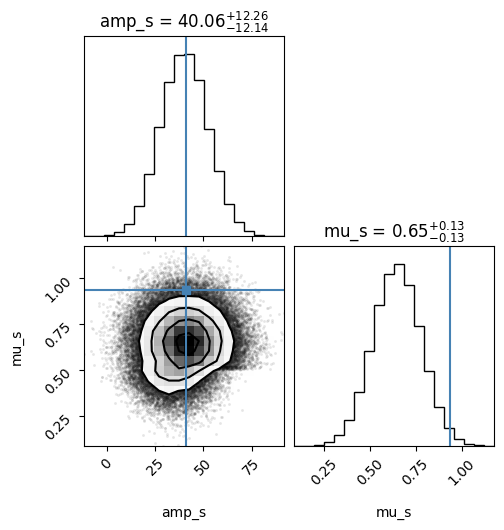

In [247]:
from einops import repeat

def sample_posterior(params, x, key, n_samples=100):
    """ Draw samples from trained flow conditioned on `x`.
    """
    def sample(npe):
        enc = npe.featurizer(x)
        enc = repeat(enc, 'n_summary -> n_samples n_summary', n_samples=n_samples)  # Repeat enc to match n_samples
        samples = npe.flow.sample(n_samples, key, enc)
        return samples
    return nn.apply(sample, npe)(params)


idx = 3
samples_post = sample_posterior(params, x_samples_test[idx], key, n_samples=100_000)

import corner

corner.corner(np.array(samples_post) * theta_std + theta_mean, truths=theta_samples_test[idx] * theta_std + theta_mean, labels=["amp_s", "mu_s"], show_titles=True, title_kwargs={"fontsize": 12});